In [ ]:
!pip install torch_cka torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import mnist

import random, os
import numpy as np
import pandas as pd
from pprint import pprint
from torchinfo import summary
from torch_cka import CKA

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
    torchvision.transforms.Lambda(lambda x : torch.flatten(x))
])

mnist_train = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=T)
mnist_test = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=T)

train_loader = DataLoader(mnist_train, shuffle=False, batch_size=256)
test_loader = DataLoader(mnist_test, batch_size=256)

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x        

In [ ]:
model1 = Net1().to(device)
opt1 = torch.optim.Adam(model1.parameters())
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 10
for epoch in range(EPOCHS):
    for (bi, batch) in enumerate(train_loader):
        opt1.zero_grad()

        x, y = batch
        x, y = x.to(device), y.to(device)

        pred = model1(x)
        loss = loss_fn(pred, y.view(-1))
        
        loss.backward()
        opt1.step()

    print ("Epoch: ", epoch)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [ ]:
model2 = Net2().to(device)
opt2 = torch.optim.Adam(model2.parameters())
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 10
for epoch in range(EPOCHS):
    for (bi, batch) in enumerate(train_loader):
        opt2.zero_grad()

        x, y = batch
        x, y = x.to(device), y.to(device)

        pred = model2(x)
        loss = loss_fn(pred, y.view(-1))
        
        loss.backward()
        opt2.step()

    print ("Epoch: ", epoch)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [ ]:
def evaluate_model(model, test_loader):
    total_cnt = 0
    correct_cnt = 0
    for bi, batch in enumerate(test_loader):
        x, y = batch
        x, y = x.to(device), y.to(device).view(-1)
        out = model(x)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == y.data).sum()    

    return correct_cnt / total_cnt

In [ ]:
print (evaluate_model(model1, test_loader))
print (evaluate_model(model2, test_loader))

tensor(0.9785, device='cuda:0')
tensor(0.9711, device='cuda:0')


In [ ]:
cka = CKA(model1, model2,
          model1_name="Shallow-MLP",   # good idea to provide names to avoid confusion
          model2_name="Deep-MLP",   
          device=device)

cka.compare(test_loader) # secondary dataloader is optional

results = cka.export()  # returns a dict that contains model names, layer names

/usr/local/lib/python3.7/dist-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


In [ ]:
from pprint import pprint

pprint (results)

{'CKA': tensor([[0.9927, 0.7532, 0.8109, 0.5710, 0.5710],
        [0.7487, 0.9701, 0.9241, 0.8748, 0.8748],
        [0.8064, 0.9318, 0.9627, 0.8156, 0.8156],
        [0.5509, 0.8697, 0.8086, 0.9585, 0.9585],
        [0.5509, 0.8697, 0.8086, 0.9585, 0.9585]]),
 'dataset1_name': 'Dataset MNIST',
 'dataset2_name': 'Dataset MNIST',
 'model1_layers': ['', 'fc1', 'fc2', 'fc3', 'droput'],
 'model1_name': 'Shallow-MLP',
 'model2_layers': ['', 'fc1', 'fc2', 'fc3', 'droput'],
 'model2_name': 'Deep-MLP'}


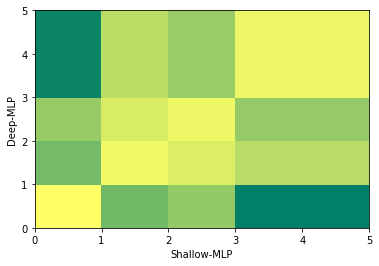

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

matrix = results['CKA'].T
# matrix = torch.flip(matrix, [0])

plt.pcolormesh(matrix, cmap="summer")
plt.xlabel(results['model1_name'])
plt.ylabel(results['model2_name'])
plt.show()